In [1]:
# CSVファイルに記載したフォルダ・PDFファイル名を読み込み、
# PDFファイルのテキストの属性情報をinfoフォルダに格納

import pandas as pd
import MeCab
import fitz
import re
import sys
sys.path.append('/work_dir') 
import talknize_module_20240909 as tk
import csv
import os
from concurrent.futures import ThreadPoolExecutor, as_completed
import matplotlib.pyplot as plt


In [2]:
import fitz  # PyMuPDF
import pandas as pd

def extract_pdf_attributes(pdf_path, page_number, output_csv_path):
    """
    指定したPDFファイルのブロック・ライン・スパン単位でデータ属性を取得し、CSV形式で出力。
    
    Args:
        pdf_path (str): PDFファイルのパス。
        page_number (int): ページ番号（1から始まる）。
        output_csv_path (str): 出力するCSVファイルのパス。
        
    Returns:
        pd.DataFrame: 取得したデータ属性を保持するデータフレーム。
    """
    try:
        # PDFを開く
        doc = fitz.open(pdf_path)
        
        # ページ番号が正しいか確認
        if page_number < 1 or page_number > len(doc):
            print(f"エラー: ページ番号は1から{len(doc)}の間で指定してください。")
            return None
        
        # 対象ページを取得（0インデックス）
        page = doc[page_number - 1]
        
        # ページ内のブロックを取得
        blocks = page.get_text("dict")["blocks"]
        
        # データ保持用リスト
        data = []
        
        for block_no, block in enumerate(blocks, start=1):
            if "lines" not in block:
                continue  # ブロックに行がない場合はスキップ
            
            for line_no, line in enumerate(block["lines"], start=1):
                if "spans" not in line:
                    continue  # 行にスパンがない場合はスキップ
                
                for span_no, span in enumerate(line["spans"], start=1):
                    # 各スパンの属性を取得
                    text = span.get("text", "")
                    bbox = line["bbox"]
                    font = span.get("font", "")
                    size = span.get("size", "")
                    color = span.get("color", "")
                    text_type = span.get("flags", "")
                    origin = span.get("origin", (None, None))  # originを取得
                    ascender = span.get("ascender", None)      # ascenderを取得
                    
                    # データをリストに追加
                    data.append({
                        "page_no": page_number,
                        "block_no": block_no,
                        "line_no": line_no,
                        "span_no": span_no,
                        "text": text,
                        "origin_x": origin[0],
                        "origin_y": origin[1],
                        "bbox_x0": bbox[0],
                        "bbox_y0": bbox[1],
                        "bbox_x1": bbox[2],
                        "bbox_y1": bbox[3],
                        "font": font,
                        "size": size,
                        "color": color,
                        "text_type": text_type,
                        "ascender": ascender,
                    })
        
        # PDFを閉じる
        doc.close()
        
        # pandasデータフレームに変換
        df = pd.DataFrame(data)
        
        # CSVとして出力
        df.to_csv(output_csv_path, index=False, encoding="utf-8-sig")
        print(f"CSVファイルが出力されました: {output_csv_path}")
        
        return df
    except Exception as e:
        print(f"エラーが発生しました: {e}")
        return None


In [3]:
# CSVを読み込む関数
def load_csv(file_path):
    """
    CSVを読み込み、DataFrameを返す
    file_path: CSVファイルのパス
    """
    try:
        return pd.read_csv(file_path)
    except FileNotFoundError:
        print(f"Error: CSV file not found at {file_path}")
        return None
    except pd.errors.EmptyDataError:
        print(f"Error: CSV file at {file_path} is empty or invalid")
        return None
    except Exception as e:
        print(f"Error reading CSV file: {e}")
        return None

CSVファイルが出力されました: ir/2025/20020_日清製粉グループ本社/info/Gx5z_attrib_page10.csv
     page_no  block_no  line_no  span_no        text     origin_x    origin_y  \
0         10         1        1        1  日清製粉グループとは   692.612183   39.008789   
1         10         1        2        1   Chapter 1   655.526001   38.827698   
2         10         1        3        1     価値創造の基盤  1028.043091   39.008789   
3         10         1        4        1   Chapter 3   990.692871   38.827698   
4         10         2        1        1     価値創造の戦略   860.068176   39.008789   
..       ...       ...      ...      ...         ...          ...         ...   
370       10       109        1        1          18    33.678001  819.000244   
371       10       109        2        1          19  1146.617920  819.000244   
372       10       109        3        1    日清製粉グループ    57.085499  818.290222   
373       10       109        4        1       統合報告書  1078.763428  818.290222   
374       10       109        4        

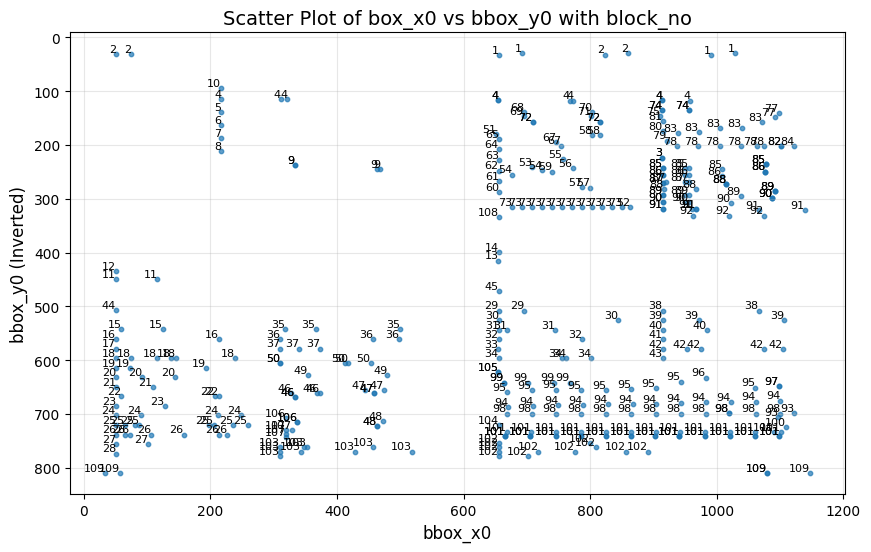

プロットが保存されました: ir/2025/20020_日清製粉グループ本社/info/Gx5z_10.png
CSVファイルが出力されました: ir/2025/22690_明治ホールディングス/info/integratedreports-integrated_reports_2024_ja_all_attrib_page10.csv
     page_no  block_no  line_no  span_no         text    origin_x    origin_y  \
0         10         1        1        1         P.40  714.330994  290.899994   
1         10         1        1        2               727.999451  290.899994   
2         10         1        2        1      サステナビリテ  714.192993  298.719971   
3         10         1        3        1          ィ戦略  751.957581  298.719971   
4         10         1        4        1          CSO  714.330994  306.899994   
..       ...       ...      ...      ...          ...         ...         ...   
224       10        46        4        1   明治グループについて  341.980011   27.618988   
225       10        46        5        1            ト  423.143005   27.618988   
226       10        46        6        1          ップメ  428.946014   27.618988   
227       10        

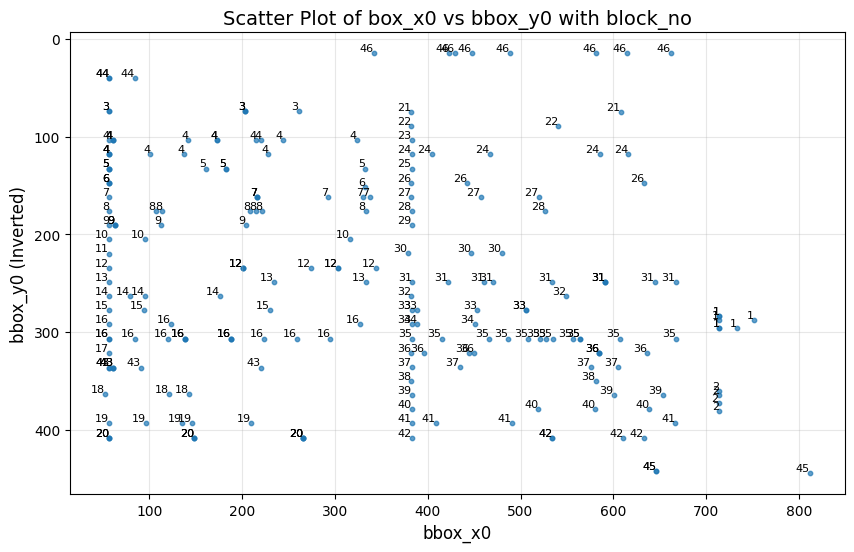

プロットが保存されました: ir/2025/22690_明治ホールディングス/info/integratedreports-integrated_reports_2024_ja_all_10.png


In [6]:
# メインルーチン

def main():
    # CSVファイルのパス
    csv_path = 'data/Attrib_Analysis_Target_20250114_test.csv'  # CSVのパスを指定

    # CSVを読み込む
    df_target = load_csv(csv_path)
    if df_target is None:
        print("Failed to load CSV. Exiting program.")
        return

    # 必要な列名を指定
    folder_col = '格納フォルダ'
    file_col = '統合報告書PDF'
    target_col = 'target_page'

    # CSVの列が期待通りか確認
    if folder_col not in df_target.columns or file_col not in df_target.columns or target_col not in df_target.columns:
        print(f"Error: CSV file must contain '{folder_col}' and '{file_col}' and '{target_page}' columns")
        return

    # 処理対象のファイルパスをリストに収集
    file_paths = []
    for index, row in df_target.iterrows():
        folder_name = 'ir/2025/' + row[folder_col]
        file_name = row[file_col]
        target_page = row[target_col]

        # パスが有効かチェック、なければリストには''を入れてデータフレームとリストの件数をそろえる、
        if pd.isna(folder_name) or pd.isna(file_name):
            print(f"Skipping row {index}: Folder or File is missing")
            file_path =''
            return

        # folder_nameとfile_nameが有効なことを前提に、属性情報抽出に必要な変数を準備 
        #file_path = os.path.join(folder_name, file_name)
        file_path = folder_name + '/' + file_name
        #file_paths.append(file_path)

        #属性情報を格納するフォルダ（info）の有無を確認、なければ作成
        info_file_path = folder_name + '/' + 'info'
        if not os.path.exists(info_file_path):
            os.makedirs(info_file_path)
        
        output_file_path = info_file_path + '/' +file_name[:len(file_name)-4] + "_attrib_page" + str(target_page) + ".csv"
        
        # 属性情報を抽出し、CSVfファイルに出力
        df_attrib = extract_pdf_attributes(file_path, target_page, output_file_path)
        #print(df_attrib)
    
        #================================================================
        #テキストボックスの始点座標のプロット（ブロック番号付き）
        # line_no=1 のデータを抽出
        plot_data = df_attrib

        # bbox_x0 と bbox_y0 をプロット (Y軸を上下反転)
        plt.figure(figsize=(10, 6))
        plt.scatter(plot_data['bbox_x0'], plot_data['bbox_y0'], alpha=0.7, s=10)
        
        # block_no を各点に表示
        for x, y, block_no in zip(plot_data['bbox_x0'], plot_data['bbox_y0'], plot_data['block_no']):
            plt.text(x, y, str(block_no), fontsize=8, ha='right', va='bottom')  # block_no をラベルとして表示
        
        plt.title('Scatter Plot of box_x0 vs bbox_y0 with block_no', fontsize=14)
        plt.xlabel('bbox_x0', fontsize=12)
        plt.ylabel('bbox_y0 (Inverted)', fontsize=12)
        plt.gca().invert_yaxis()  # Y軸を上下反転
        plt.grid(alpha=0.3)
        
        # プロットを保存
        plot_file_path = info_file_path + '/' +file_name[:len(file_name)-4] + '_' +str(target_page) + ".png"
        # DPIを設定し保存
        plt.savefig(plot_file_path, dpi=300, bbox_inches='tight')  
        # プロットを表示
        #plt.show()
        print(f"プロットが保存されました: {plot_file_path}")







if __name__ == "__main__":
    main()

#順に企業コード・企業名・PDFファイル名を取り込み


In [5]:
# 使用例
# 対象のPDFファイルを指定
#pdf_file = "ir/2025/34070_旭化成/24jp.pdf"  
base_dir = "ir/2025/"
#base_dir = "ir/2024/"

#pdf_dir =  "34070_旭化成"
#pdf_filename = "24jp.pdf"
pdf_dir =  "40040_レゾナック・ホールディングス"
pdf_filename = "pdf-sustainability-report-integratedreport-RESONAC24J_spread.pdf"
#pdf_dir =  "41880_三菱ケミカルグループ"
#pdf_filename = "23.pdf"

pdf_path = base_dir + pdf_dir + "/" + pdf_filename

page_num = 6  # 表示したいページ番号（1ページ目）
#extract_line_bbox_and_text(pdf_path, page_number)
#analyze_line_distances(pdf_file, page_num)
output_file_path = pdf_path[:len(pdf_path)-4] + "_attrib_page" + str(page_num) + ".csv"
# 属性を抽出し、CSVに出力
df = extract_pdf_attributes(pdf_path, page_num, output_file_path)

# pandasデータフレームを確認
if df is not None:
    print(df.head())



CSVファイルが出力されました: ir/2025/40040_レゾナック・ホールディングス/pdf-sustainability-report-integratedreport-RESONAC24J_spread_attrib_page6.csv
   page_no  block_no  line_no  span_no    text     origin_x    origin_y  \
0        6         1        1        1      10  1067.396851  660.833618   
1        6         2        1        1  データセクシ  1017.863770   23.243896   
2        6         2        2        1       ョ  1057.109619   23.243896   
3        6         2        3        1       ン  1062.807251   23.243896   
4        6         2        4        1   コーポレー   897.561646   23.243896   

       bbox_x0     bbox_y0      bbox_x1     bbox_y1               font  \
0  1067.396851  651.858154  1076.860962  663.472961       DIN2014-Bold   
1  1017.863770   14.761236  1058.427612   25.972237  UDShinGoPr6N-Bold   
2  1057.109619   14.761236  1064.196167   25.972237  UDShinGoPr6N-Bold   
3  1062.807251   14.761236  1069.893799   25.972237  UDShinGoPr6N-Bold   
4   897.561646   14.761236   931.391663   25.972237  UD

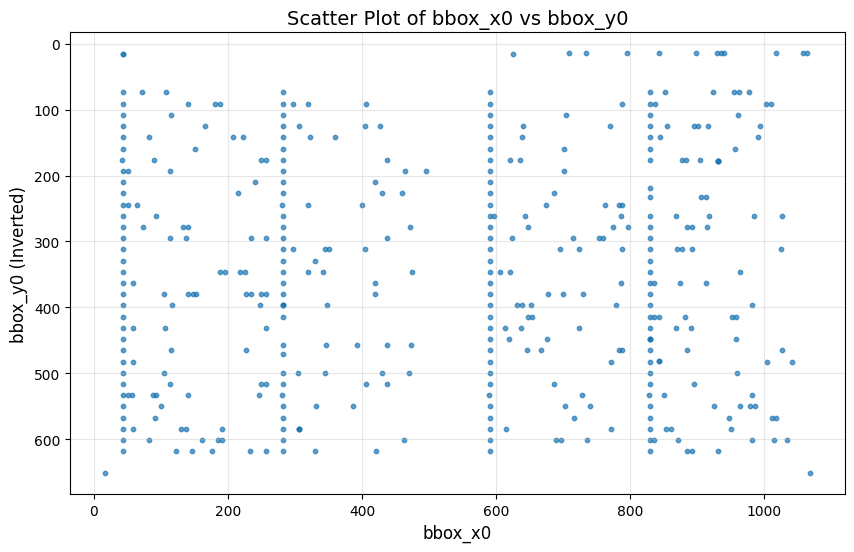

In [6]:
import matplotlib.pyplot as plt

# line_no=1 のデータを抽出
line_1_data = df

# bbox_x0 と bbox_y0 をプロット (Y軸を上下反転)
plt.figure(figsize=(10, 6))
plt.scatter(line_1_data['bbox_x0'], line_1_data['bbox_y0'], alpha=0.7, s=10)
plt.title('Scatter Plot of bbox_x0 vs bbox_y0', fontsize=14)
plt.xlabel('bbox_x0', fontsize=12)
plt.ylabel('bbox_y0 (Inverted)', fontsize=12)
plt.gca().invert_yaxis()  # Y軸を上下反転
plt.grid(alpha=0.3)
plt.show()



In [7]:
sorted_y0 = df.sort_values(by='bbox_y0', ascending=False)[['bbox_x0', 'bbox_y0', 'text']]
sorted_y0.head(10)

,bbox_x0,bbox_y0,text
0,1067.396851,651.858154,10
13,17.114500,651.858154,09
404,330.595947,618.158936,従業員のエンゲージメン
403,281.894135,618.158936,ているのは、
405,421.605469,618.158936,トを上げていくことで
325,930.271606,618.158020,です。
324,891.807556,618.158020,ンの創出」
323,884.953430,618.158020,ョ
322,829.125244,618.158020,創型イノベーシ
213,233.471924,618.157532,ンは、


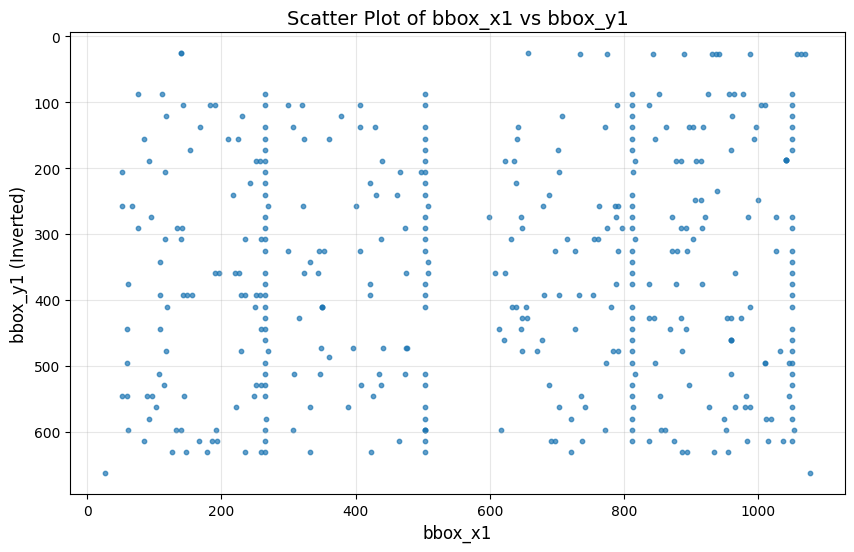

In [8]:
import matplotlib.pyplot as plt

# line_no=1 のデータを抽出
line_1_data = df

# bbox_x0 と bbox_y0 をプロット (Y軸を上下反転)
plt.figure(figsize=(10, 6))
plt.scatter(line_1_data['bbox_x1'], line_1_data['bbox_y1'], alpha=0.7, s=10)
plt.title('Scatter Plot of bbox_x1 vs bbox_y1', fontsize=14)
plt.xlabel('bbox_x1', fontsize=12)
plt.ylabel('bbox_y1 (Inverted)', fontsize=12)
plt.gca().invert_yaxis()  # Y軸を上下反転
plt.grid(alpha=0.3)
plt.show()


In [9]:
sorted_y1 = df.sort_values(by='bbox_y1', ascending=True)[['bbox_x0', 'bbox_y0', 'text']]
sorted_y1.head(20)


,bbox_x0,bbox_y0,text
15,43.827202,15.296995,REPORT 2024
14,43.827202,15.296995,RESONAC
12,625.770630,15.296995,Contents
11,733.712402,14.761236,クの自己紹介
10,708.200623,14.761236,レゾナッ
8,795.670532,14.761236,目指すものとク
7,940.245605,14.761236,ガバナンス改革
9,842.019775,14.761236,リアすべきもの
5,929.852417,14.761236,ト
4,897.561646,14.761236,コーポレー


In [10]:
# line_no=1 のデータを抽出し、コピーを作成
line_1_data = df[df['line_no'] == 1].copy()

# bbox_x0 を一定の範囲で丸めてグルーピング
grouping_range = 10  # 10単位でグルーピング
line_1_data['group'] = (line_1_data['bbox_x0'] // grouping_range) * grouping_range

# グループごとに bbox_x0 の最小値と最大値を算出
bbox_x0_groups = line_1_data.groupby('group')['bbox_x0'].agg(['min', 'max', 'count']).reset_index()

# 結果をテキストで出力
#for _, row in bbox_x0_groups.iterrows():
#    print(f"Group: {row['group']} - Min: {row['min']}, Max: {row['max']}, Count: {row['count']}")

# 結果をテキストで出力（小数点2桁で四捨五入）
output_file_path = pdf_path[:len(pdf_path)-4] + "_bbox_x0_counts_page_" + str(page_num) + ".txt"
#output_file_path = 'output.txt'  # 保存するファイル名

with open(output_file_path, 'w', encoding='utf-8') as f:
    print('---- bbox_x0 (line1) counts by range group ----')  # ヘッダーを書き込み
    f.write('---- bbox_x0 (line1) counts by range group ----\n')  # ヘッダーを書き込み
    for _, row in bbox_x0_groups.iterrows():
        min_value = round(row['min'], 2)  # 小数点2桁で四捨五入
        max_value = round(row['max'], 2)  # 小数点2桁で四捨五入
        line = f"Group: {row['group']} - Min: {min_value}, Max: {max_value}, Count: {row['count']}\n"
        print(line.strip())  # コンソールにも出力
        f.write(line)  # ファイルにも書き込み


---- bbox_x0 (line1) counts by range group ----
Group: 10.0 - Min: 17.11, Max: 17.11, Count: 1.0
Group: 40.0 - Min: 42.98, Max: 43.94, Count: 35.0
Group: 280.0 - Min: 281.32, Max: 282.05, Count: 32.0
Group: 590.0 - Min: 590.06, Max: 591.02, Count: 33.0
Group: 820.0 - Min: 828.41, Max: 829.13, Count: 32.0
Group: 1010.0 - Min: 1017.86, Max: 1017.86, Count: 1.0
Group: 1060.0 - Min: 1067.4, Max: 1067.4, Count: 1.0


In [11]:
import numpy as np  # 繰り上げ計算用

# Count > 1 を満たすグループを抽出
filtered_groups = bbox_x0_groups[bbox_x0_groups['count'] > 1]

# 最大値を繰り上げて整数にする
rounded_max_values = np.ceil(filtered_groups['max']).astype(int).tolist()

# 結果を表示
print(rounded_max_values)


[44, 283, 592, 830]


In [12]:
# 最小値を切り下げて整数にする
rounded_min_values = np.floor(bbox_x0_groups['min']).astype(int).tolist()
filtered_rounded_min_values = np.floor(filtered_groups['min']).astype(int).tolist()

# 結果を表示
print(rounded_min_values)
print(filtered_rounded_min_values)

[17, 42, 281, 590, 828, 1017, 1067]
[42, 281, 590, 828]


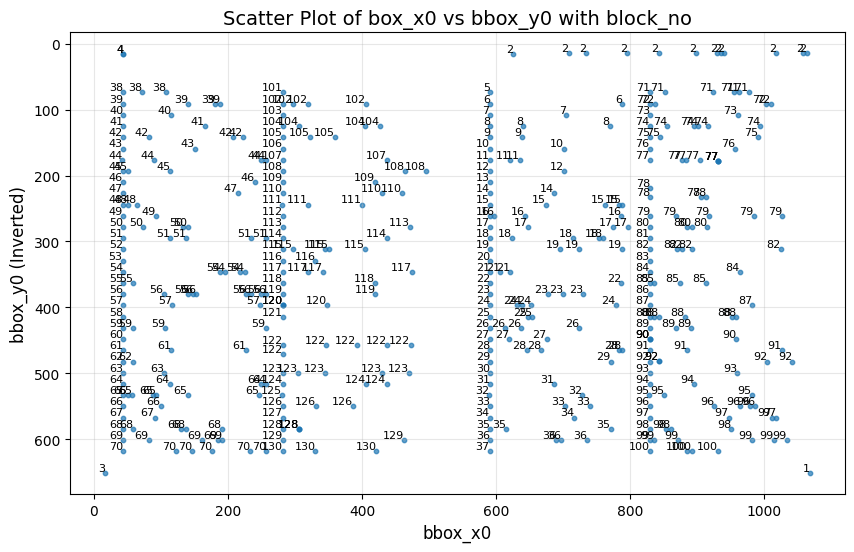

プロットが保存されました: ir/2025/40040_レゾナック・ホールディングス/pdf-sustainability-report-integratedreport-RESONAC24J_spread_block_no_plot_page_6.png


In [13]:
import matplotlib.pyplot as plt

# line_no=1 のデータを抽出
line_1_data = df

# bbox_x0 と bbox_y0 をプロット (Y軸を上下反転)
plt.figure(figsize=(10, 6))
plt.scatter(line_1_data['bbox_x0'], line_1_data['bbox_y0'], alpha=0.7, s=10)

# block_no を各点に表示
for x, y, block_no in zip(line_1_data['bbox_x0'], line_1_data['bbox_y0'], line_1_data['block_no']):
    plt.text(x, y, str(block_no), fontsize=8, ha='right', va='bottom')  # block_no をラベルとして表示

plt.title('Scatter Plot of box_x0 vs bbox_y0 with block_no', fontsize=14)
plt.xlabel('bbox_x0', fontsize=12)
plt.ylabel('bbox_y0 (Inverted)', fontsize=12)
plt.gca().invert_yaxis()  # Y軸を上下反転
plt.grid(alpha=0.3)

# プロットを保存
output_file_path = pdf_path[:len(pdf_path)-4] + "_block_no_plot_page_" + str(page_num) + ".png"
plt.savefig(output_file_path, dpi=300, bbox_inches='tight')  # DPIを設定して高解像度で保存

# プロットを表示
plt.show()

print(f"プロットが保存されました: {output_file_path}")
